In [48]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)

In [49]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")

In [50]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

In [51]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [52]:
head(meta_new)

subject_id,sample_id,time,cc,age_d,age_d_s,bf_count,bf_count_s,bf_ratio
207,sa_10000,post,no,98.00,0.0320946,6.00,0.43948544,1
388,sa_10038,post,yes,98.00,0.0320946,0.00,-1.65710371,0
381,sa_10118,post,yes,108.00,0.5275689,6.59,0.64565004,1
283,sa_10211,post,yes,107.03,0.4795079,5.00,0.09005391,1
216,sa_10230,post,no,100.00,0.1311895,7.00,0.78891696,1
277,sa_10247,pre,yes,79.00,-0.9093066,6.10,0.47442859,1


In [53]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [54]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Setting row names on a tibble is deprecated.”Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PERMANOVA

In [55]:
otus.rel

ERROR: Error in eval(expr, envir, enclos): object 'otus.rel' not found


In [ ]:
# how many NA? --> 4 CC and 1 no CC
# sd_to_df(pseq.rel) %>% filter(is.na(bf_count_s))
# complete cases for meta data and otus:
meta.rel <- sd_to_df(pseq.rel) %>% na.omit()
otus.rel <- otu_to_df(pseq.rel, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.rel$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.rel)
anova(betadisper(dist, meta.rel$cc))
anova(betadisper(dist, meta.rel$time))
anova(betadisper(dist, meta.rel$groups))
pm <- adonis(otus.rel ~ time * cc + age_d_s + bf_count_s, method = "bray", data = meta)

In [ ]:
pm$aov.tab

In [ ]:
coef_v <- c("time1", "age_d_s", "bf_count_s", "time1:cc1")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.055, 0.03) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here("fig/permanova.png"))
    p
})
pmps

In [ ]:
### make tables for permanovs apa
pm_table <- rownames_to_column(pm$aov.tab, "Model Parameters")
pm_table <- 
  mutate_if(pm_table, is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`)) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)
colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )

In [ ]:
pm_table

# Principal Coordinate Analysis

In [ ]:
# PCoA bray, can we differentiate the post CC from all other infants?
cc_pcoa <- ordinate(pseq.rel, method = "PCoA", distance = "bray")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq.rel, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 
# axes 2:3
plot_ordination(pseq.rel, cc_pcoa, color = "groups", axes = 2:3) +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 

# Hierarchical Generalized Linear Models

In [ ]:
library(brms)
library(broom)
library(parallel)
options(mc.cores = 6)

In [ ]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium_\\(sensu_stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- gsub(" ", "_", colnames(otus.clr))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")

## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

In [ ]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [ ]:
dir.create(here("models/final_analyses"))
folder <- here("models/final_analyses")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson", "fisher")

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [ ]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [58]:
prior <- 
    c(
        set_prior("normal(0, 2)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )

brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [59]:
# gaussian family and listwise deletion
div_models <- lapply(diversity_index, brm_div)

In [60]:
# gaussian and mi for bf_count_s missingness
div_models_mi <- lapply(diversity_index, brm_div_mi)

In [227]:
div_models_mi

[[1]]
 Family: MV(gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity 
Formula: shannon | mi() ~ cc * time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s) | subject_id) 
         bf_count_s | mi() ~ cc * time + shannon + age_d_s + (1 + time + age_d_s + shannon | subject_id) 
   Data: data (Number of observations: 196) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~subject_id (Number of levels: 98) 
                                            Estimate Est.Error l-95% CI
sd(shannon_Intercept)                           0.27      0.04     0.18
sd(shannon_timepost)                            0.05      0.05     0.00
sd(shannon_age_d_s)                             0.04      0.03     0.00
sd(shannon_mibf_count_s)                        0.04      0.04     0.00
sd(bfcounts_Intercept)                          0.39      0.25     0.01
sd(bfcount

In [61]:
# skew family and listwise deletion
div_models_skew <- lapply(diversity_index, brm_div_skew)

In [62]:
# skew family and mi for bf_count_s missingness
div_models_skew_mi <- lapply(diversity_index, brm_div_skew_mi)

In [108]:
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
pp_div <- 
    lapply(1:length(div_models), function(x) {
       pp_plot(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_skew <-
    lapply(1:length(div_models_skew), function(x) {
       pp_plot(div_models_skew[[x]], 10,  diversity_index[x])

    } )
pp_div_skew_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew[[x]], 10,  diversity_index[x])
    } )
pp_div_mi <- 
    lapply(1:length(div_models_mi), function(x) {
       pp_plot(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi <-
    lapply(1:length(div_models_skew_mi), function(x) {
       pp_plot(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )

In [224]:
lapply(div_models_skew, function(x) {
    tidy(x)[1:13,]
})

term,estimate,std.error,lower,upper
b_Intercept,1.873625639,0.09073203,1.726028215,2.02513604
b_ccyes,0.039488444,0.10098847,-0.124199115,0.20798433
b_timepost,-0.001881561,0.11744673,-0.197346249,0.19246691
b_age_d_s,0.077147826,0.06427346,-0.029695315,0.18378103
b_bf_count_s,-0.068688689,0.03763706,-0.131154748,-0.00583984
b_ccyes:timepost,-0.265042463,0.10131452,-0.429905034,-0.09944182
sd_subject_id__Intercept,0.274633468,0.04722129,0.196737573,0.35022521
sd_subject_id__timepost,0.079016163,0.06848527,0.004380602,0.21269342
sd_subject_id__age_d_s,0.042840482,0.03260594,0.003656768,0.10494146
sd_subject_id__bf_count_s,0.046559335,0.03856060,0.003502045,0.12335905


In [400]:
lapply(div_models_skew_mi, function(x) {
    tidy(x)[1:13,]
})
#lapply(div_models_skew_mi, plot)

term,estimate,std.error,lower,upper
b_shannon_Intercept,1.88439961,0.08948574,1.733681580,2.03161369
b_bfcounts_Intercept,0.45135456,0.27270598,0.005144036,0.90418466
b_shannon_ccyes,0.04833789,0.09769097,-0.112292605,0.20676035
b_shannon_timepost,-0.03032499,0.11477478,-0.218164353,0.15692999
b_shannon_age_d_s,0.09938759,0.06182313,-0.002107777,0.20223886
b_shannon_ccyes:timepost,-0.26439782,0.09542340,-0.423324577,-0.10367155
b_bfcounts_ccyes,-0.01936861,0.18564966,-0.323159946,0.28671921
b_bfcounts_timepost,-0.37378396,0.21556695,-0.732124668,-0.01618459
b_bfcounts_shannon,-0.15262150,0.12165606,-0.357031937,0.04574673
b_bfcounts_age_d_s,-0.15062888,0.13667574,-0.376072936,0.07560964


In [401]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost")) %>%
        rename(
            no_pre = glue("b_{var_name}_Intercept"), 
            yes_pre = glue("b_{var_name}_ccyes"),
            no_post = glue("b_{var_name}_timepost"),
            yes_post = glue("b_{var_name}_ccyes:timepost")) %>%
        mutate(
            yes_post = no_pre + yes_pre + no_post + yes_post,
            no_post = no_pre + no_post,
            yes_pre = no_pre + yes_pre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}


In [398]:
diversity_index
lapply(1:length(diversity_index), function(x) {
    df <- calc_treatment_effect(div_models_skew_mi[[x]], diversity_index[x], summarise = F)
    df <- df %>% 
        mutate(            
            yespost_yespre = yes_post - yes_pre,
            yespost_nopre = yes_post - no_pre,
            yespost_nopost = yes_post - no_post) %>%
        select(yespost_yespre, yespost_nopre, yespost_nopost) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df
})


[1] "shannon"         "inverse_simpson" "gini_simpson"    "fisher"

comparison,mean_diff,lower,upper,prob
yespost_nopost,-0.2160599,-0.3882106,-0.03516960,0.99100
yespost_nopre,-0.2463849,-0.5434585,0.06163021,0.94525
yespost_yespre,-0.2947228,-0.5216191,-0.07639218,0.99475
comparison,mean_diff,lower,upper,prob
yespost_nopost,-0.3759450,-0.7077399,0.0007420919,0.98475
yespost_nopre,-0.4442919,-0.9600468,0.0832542908,0.95575
yespost_yespre,-0.3302808,-0.7623558,0.0837505322,0.94300
comparison,mean_diff,lower,upper,prob
yespost_nopost,-0.06903307,-0.1319448,-0.007796998,0.98450
yespost_nopre,-0.09578488,-0.2026079,0.005326078,0.96750


Warning message:
“Ignoring unknown aesthetics: y”Warning message:
“Ignoring unknown aesthetics: y”Warning message:
“Ignoring unknown aesthetics: y”Warning message:
“Ignoring unknown aesthetics: y”

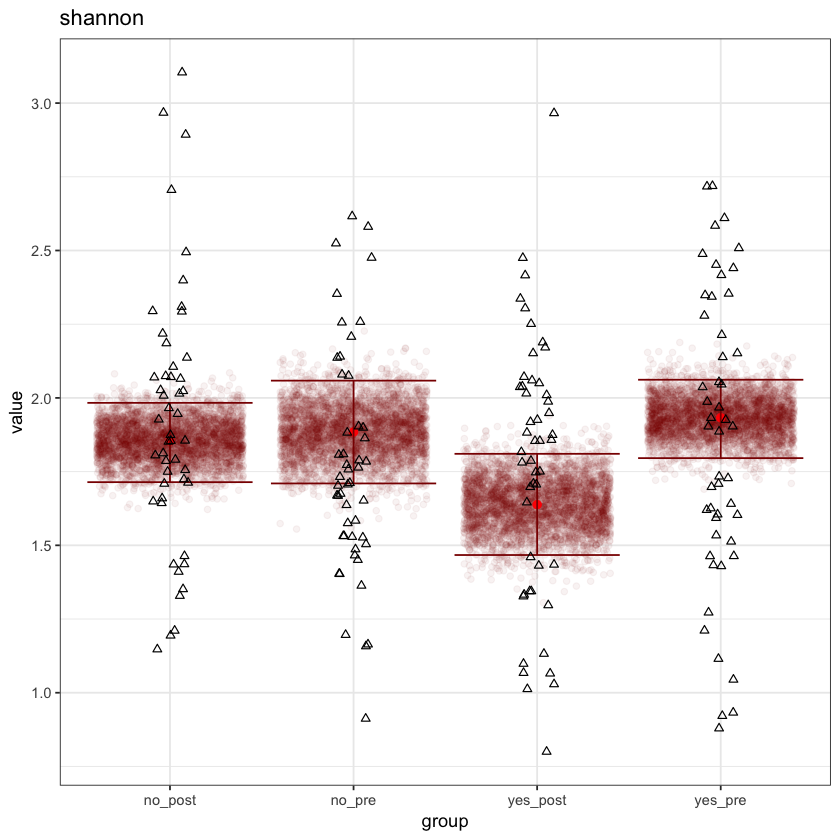

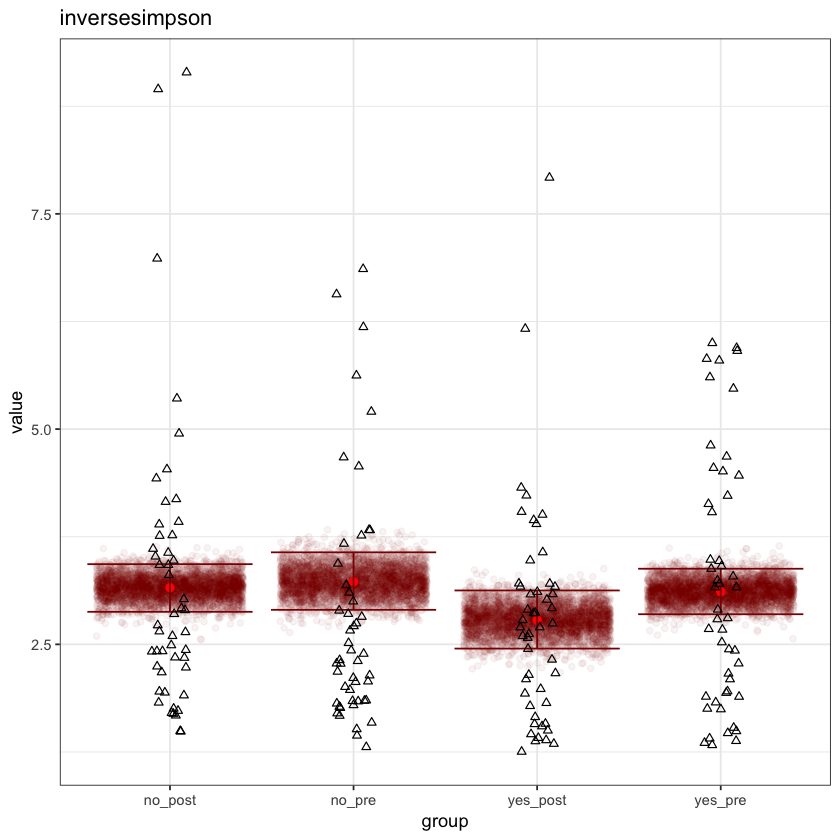

[[1]]

[[2]]

[[3]]

[[4]]


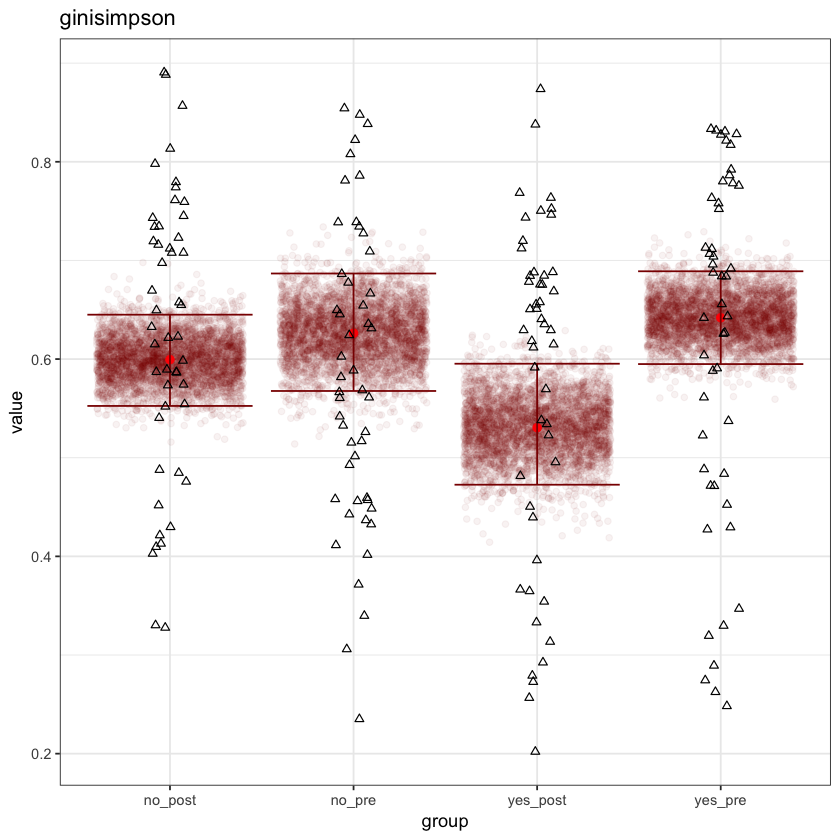

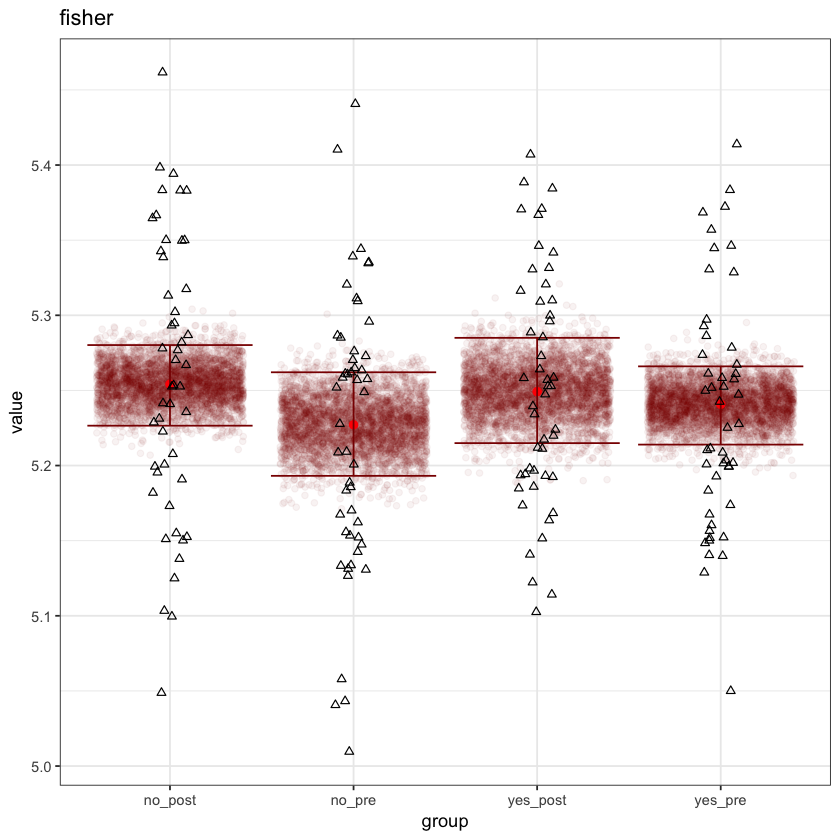

In [402]:
meta <- meta %>% mutate(
    group = ifelse(groups == "noCCpost", "no_post", ifelse(groups == "CCpost", "yes_post", ifelse(groups == "CCpre", "yes_pre", "no_pre")))
)
lapply(1:length(diversity_index), function(x) {
    plot_effects(div_models_skew_mi[[x]], diversity_index[x]) +
        geom_jitter(data = meta, aes_string("group", diversity_index[x]), width = 0.1, shape = 2)
    })


# Differential abundance testing